install some libraries

In [12]:
!pip install bert-for-tf2

Import some libraries

In [13]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os
import numpy as np
import tensorflow as tf
from bert import BertModelLayer
from bert.loader import StockBertConfig,map_stock_config_to_params, load_stock_weights
from keras.layers import Input
from keras.utils import plot_model
import keras
from bert import bert_tokenization

Download Data

In [14]:
!gdown --id 1OlcvGWReJMuyYQuOZm149vHWwPtlboR6 --output train.csv
!gdown --id 1Oi5cRlTybuIF2Fl5Bfsr-KkqrXrdt77w --output valid.csv
!gdown --id 1ep9H6-HvhB4utJRLVcLzieWNUSG3P_uF --output test.csv

Downloading...
From: https://drive.google.com/uc?id=1OlcvGWReJMuyYQuOZm149vHWwPtlboR6
To: /content/train.csv
100% 799k/799k [00:00<00:00, 106MB/s]
Downloading...
From: https://drive.google.com/uc?id=1Oi5cRlTybuIF2Fl5Bfsr-KkqrXrdt77w
To: /content/valid.csv
100% 43.3k/43.3k [00:00<00:00, 66.2MB/s]
Downloading...
From: https://drive.google.com/uc?id=1ep9H6-HvhB4utJRLVcLzieWNUSG3P_uF
To: /content/test.csv
100% 43.1k/43.1k [00:00<00:00, 41.0MB/s]


load data in panda dataframes

In [15]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
valid = pd.read_csv('valid.csv')
print('num of train examples : {} \nnum of validation example: {} \nnum of test examples :{}'.
      format(train.shape[0],valid.shape[0],test.shape[0]))
print(train.head())

num of train examples : 13084 
num of validation example: 700 
num of test examples :700
                                                text         intent
0   listen to westbam alumb allergic on google music      PlayMusic
1         add step to me to the 50 clásicos playlist  AddToPlaylist
2  i give this current textbook a rating value of...       RateBook
3               play the song little robin redbreast      PlayMusic
4  please add iris dement to my playlist this is ...  AddToPlaylist


Check if we have enough data for every category

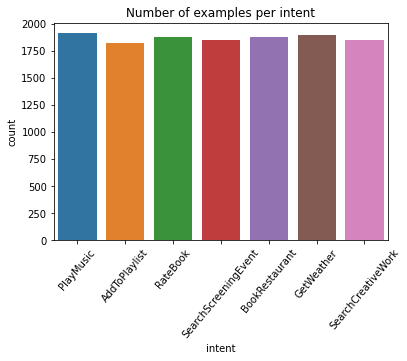

In [16]:
chart = sns.countplot(train.intent)
plt.title("Number of examples per intent")
chart.set_xticklabels(chart.get_xticklabels(),Rotation = 50)
plt.show()

Downlod Bert model

In [17]:
!wget https://storage.googleapis.com/bert_models/2019_05_30/wwm_uncased_L-24_H-1024_A-16.zip
!unzip wwm_uncased_L-24_H-1024_A-16.zip
os.makedirs('model',exist_ok = True)
!mv wwm_uncased_L-24_H-1024_A-16/ model

--2020-08-13 07:04:51--  https://storage.googleapis.com/bert_models/2019_05_30/wwm_uncased_L-24_H-1024_A-16.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 173.194.203.128, 74.125.20.128, 74.125.142.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|173.194.203.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1248381879 (1.2G) [application/zip]
Saving to: ‘wwm_uncased_L-24_H-1024_A-16.zip’

wwm_uncased_L-24_H- 100%[===================>]   1.16G   109MB/s    in 12s     

2020-08-13 07:05:03 (100 MB/s) - ‘wwm_uncased_L-24_H-1024_A-16.zip’ saved [1248381879/1248381879]

Archive:  wwm_uncased_L-24_H-1024_A-16.zip
   creating: wwm_uncased_L-24_H-1024_A-16/
  inflating: wwm_uncased_L-24_H-1024_A-16/bert_model.ckpt.meta  
  inflating: wwm_uncased_L-24_H-1024_A-16/bert_model.ckpt.data-00000-of-00001  
  inflating: wwm_uncased_L-24_H-1024_A-16/vocab.txt  
  inflating: wwm_uncased_L-24_H-1024_A-16/bert_model.ckpt.index  
  inflati

Define Bert file addresses

In [18]:
bert_model_name = 'wwm_uncased_L-24_H-1024_A-16'
bert_dir = os.path.join('model/',bert_model_name)
bert_ckpt_file = os.path.join(bert_dir, 'bert_model.ckpt')
bert_config_file = os.path.join(bert_dir, 'bert_config.json')
bert_vocab_file = os.path.join(bert_dir, 'vocab.txt')

Preprocess data
1. tokenization
2. padding

In [41]:
class Preprocessor:
  DATA_COLUMN = 'text'
  LABEL_COLUMN = 'intent'
  def __init__(self, train, valid, test, tokenizer, classes):
    self.maxlen = 0 
    self.tokenizer = tokenizer
    self.classes = classes

    self.train_x , self.train_y = self.prepare(train)
    self.valid_x , self.valid_y = self.prepare(valid)
    self.test_x , self.test_y = self.prepare(test)
    self.train_x = self.pad(self.train_x)
    self.test_x = self.pad(self.test_x)
    self.valid_x = self.pad(self.valid_x)

    self.train_x = np.array(self.train_x)
    self.train_y = np.array(self.train_y)
    
    self.valid_x = np.array(self.valid_x)
    self.valid_y = np.array(self.valid_y)

    self.test_x = np.array(self.test_x)
    self.test_y = np.array(self.test_y)

  def prepare(self, df):
    x, y = [], []
    for text,intent in zip(df.text,df.intent):
      tokens = tokenizer.tokenize(text)
      tokens = ['[CLS]']+ tokens+ ['[SEP]']
      tokenIds =self.tokenizer.convert_tokens_to_ids(tokens)
      self.maxlen = max(self.maxlen, len(tokenIds))
      x.append(tokenIds)
      y.append(classes.index(intent))
    return x,y

  def pad(self,ids):
    x = []
    for input_ids in ids:
      input_ids = input_ids + [0] * (self.maxlen - len(input_ids))
      x.append(np.array(input_ids))
    return x


Find out how many classes we have and what are they

In [42]:
# extract intent classes
classes = []
for elem in train['intent']:
  if elem not in classes:
    classes.append(elem)
print(classes)

['PlayMusic', 'AddToPlaylist', 'RateBook', 'SearchScreeningEvent', 'BookRestaurant', 'GetWeather', 'SearchCreativeWork']


In [43]:
tokenizer = bert_tokenization.FullTokenizer(vocab_file = bert_vocab_file)
data = Preprocessor( train, valid, test, tokenizer, classes )

Create a classification Model
1. first layer is a Bert layer and its weights is loaded in it
2. then there is a lambda
3. after that there is a dropout to prevent overfitting
4. next there is a dense
5. and then again a dropout layer
6. and finally an output layer with number of neurons equal to number of classes

In [22]:
def CreateModel(maxLen, bert_config_file, bert_ckpt_file):
  with tf.io.gfile.GFile(bert_config_file,'r') as reader:
      bc = StockBertConfig.from_json_string(reader.read())
      bert_params = map_stock_config_to_params(bc)
      bert_params.adapter_size = None
      bert = BertModelLayer.from_params(bert_params, name="bert")
  
  input = Input(shape = (maxLen, ), dtype='int32', name = 'input_ids')
  bert_output = bert(input)

  cls_out = keras.layers.Lambda(lambda seq: seq[:, 0, :])(bert_output)
  cls_out = keras.layers.Dropout(0.5)(cls_out)

  logits = keras.layers.Dense(units=1024, activation="tanh")(cls_out)
  logits = keras.layers.Dropout(0.5)(logits)

  logits = keras.layers.Dense(units=len(classes),activation="softmax")(logits)

  model = keras.Model(inputs=input, outputs=logits)

  plot_model(model)

  model.build(input_shape=(None, maxLen))

  load_stock_weights(bert, bert_ckpt_file)
  
  return model

In [23]:
model = CreateModel(data.maxlen, bert_config_file, bert_ckpt_file)

Done loading 388 BERT weights from: model/wwm_uncased_L-24_H-1024_A-16/bert_model.ckpt into <bert.model.BertModelLayer object at 0x7f5cbba3dc50> (prefix:bert). Count of weights not found in the checkpoint was: [0]. Count of weights with mismatched shape: [0]
Unused weights from checkpoint: 
	bert/embeddings/token_type_embeddings
	bert/pooler/dense/bias
	bert/pooler/dense/kernel
	cls/predictions/output_bias
	cls/predictions/transform/LayerNorm/beta
	cls/predictions/transform/LayerNorm/gamma
	cls/predictions/transform/dense/bias
	cls/predictions/transform/dense/kernel
	cls/seq_relationship/output_bias
	cls/seq_relationship/output_weights


In [24]:
model.compile(
  optimizer=keras.optimizers.Adam(1e-5),
  loss = keras.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=[keras.metrics.SparseCategoricalAccuracy(name="acc")]
)

Train the model with recomanded epochs and batch size

In [30]:
early_stopping = keras.callbacks.EarlyStopping(patience = 1 );
history = model.fit(
  x = data.train_x,
  epochs = 5,
  y = data.train_y,
  validation_split = 0.1,
  batch_size = 16,
  shuffle = True,
  callbacks = [early_stopping]
)

Epoch 1/5
736/736 [==============================] - 532s 723ms/step - loss: 1.1775 - acc: 0.9879 - val_loss: 1.1814 - val_acc: 0.9840
Epoch 2/5
736/736 [==============================] - 532s 723ms/step - loss: 1.1779 - acc: 0.9876 - val_loss: 1.1805 - val_acc: 0.9847
Epoch 3/5
736/736 [==============================] - 531s 721ms/step - loss: 1.1771 - acc: 0.9885 - val_loss: 1.1839 - val_acc: 0.9809


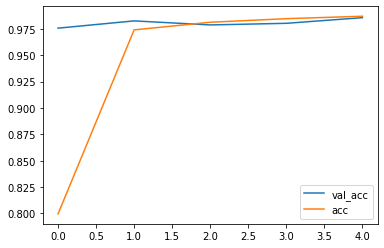

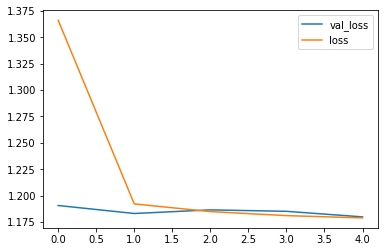

In [29]:
plt.plot(history.history['val_acc'])
plt.plot(history.history['acc'])
plt.legend(['val_acc','acc'])
plt.show()
plt.plot(history.history['val_loss'])
plt.plot(history.history['loss'])
plt.legend(['val_loss','loss'])
plt.show()

evaluate on test data

In [52]:
eval = model.evaluate(data.test_x,data.test_y,batch_size=16)
for metric,metric_name in zip(eval,model.metrics_names):
  print('{} : {}'.format(metric_name,np.round(metric,2)))

44/44 [==============================] - 7s 153ms/step - loss: 1.1927 - acc: 0.9729
loss : 1.19
acc : 0.97


Predict some text's intent

In [75]:
from random import randint
ind=randint(0,len(data.test_y))
print(test.text[ind])
print('actual result: {}'.format(test.intent[ind]))
predicted_result_ind = np.argmax(
    model.predict(
    np.array(data.test_x[ind:ind+1])
    )[0]
)
predicted_result = classes[predicted_result_ind]
print('predict result: {}'.format(predicted_result))

what movies are around here
actual result: SearchScreeningEvent
predict result: SearchScreeningEvent
